## comparison of calculation times for:
* Laplace calculated by for loop
* Laplace calculated with convolution by:
    * 3x3 stencil
    * 5x5 stencil

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

In [90]:
# use autoreload as loopimp might be modified
%load_ext autoreload
%autoreload 1
%aimport loopimp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
def init_tumor2(size, radius):
    """
     initializes the field phi with a circle
     :param size: size of matrix
     :param radius: tumor initial radius (created in center)
     :return param phi: order parameter matrix
    """
    cx,cy = int(size/2),int(size/2)
    x, y = np.indices((size, size))
    phi = (np.abs(np.hypot(x-cx, y-cy)) < radius).astype(int)
    return phi

In [92]:
def init_chemical_field(sigma, S, radius, position):
    """
      initialize the chemical field sigma and the nutrient sources
    :param sigma: nutrient chemical field
    :param S: source of the nutrient
    :param radius: the radius of the region where the sources will be placed
    :param position: the center of the region
    :return:
    """
    for i in range(0, sigma.size):
        s = np.asarray(np.unravel_index(i, sigma.shape))
        #distance = np.sqrt(np.sum(np.power(s - position, 2)))
        #if distance >= radius* np.sin(np.random.rand()) + 10:
        S.itemset(i, 2.75 )
        sigma.itemset(i, 2.75 )
    return sigma, S

In [93]:
def integrate_5(phi, sigma, S, dt, h, **kwargs):
    """
      integrate the order parameter phi and the chemical field sigma one tstep
      with 5x5 stencil (five point stencil - https://en.wikipedia.org/wiki/Five-point_stencil)
    :param phi: order parameter
    :param sigma: nutrient
    :param S: source of nutrient
    :param tstep: total number of timesteps
    :param dt: time increment
    :param kwargs: dictionary of parameters lambda, tau, chi, A, epsilon, delta, gamma
    :return:
    """
    stencil_5 = (1.0 / (12.0 * h * h)) * np.array(
        [[0, 0, -1, 0, 0],
         [0, 0, 16, 0, 0],
         [-1, 16, -60, 16, -1],
         [0, 0, 16, 0, 0],
         [0, 0, -1, 0, 0]])

    phiold = np.copy(phi)
    phinew = phi + dt * (kwargs['lambda_'] * convolve(phi, stencil_5, mode='nearest') +
                      (1.0/kwargs['tau']) * phi * (1.0 - phi) * (phi - 0.5) +
                      kwargs['chi'] * sigma * phi - kwargs['A'] * phi)
    # take care, tau was previously not inversed here!
    sigmanew = sigma + dt * (kwargs['epsilon'] * convolve(sigma, stencil_5, mode='nearest') +
                              S - kwargs['delta'] * phiold - kwargs['gamma'] * sigma)    
    
    return phinew, sigmanew

In [94]:
def integrate_3(phi, sigma, S, dt, h, **kwargs):
    """
      integrate the order parameter phi and the chemical field sigma one tstep
      with 3x3 stencil
    :param phi: order parameter
    :param sigma: nutrient
    :param S: source of nutrient
    :param tstep: total number of timesteps
    :param dt: time increment
    :param kwargs: dictionary of parameters lambda, tau, chi, A, epsilon, delta, gamma
    :return:
    """
    stencil_3 = (1.0 / (1.0 * h * h)) * np.array(
        [[0,1,0],
         [1,-4,1],
         [0,1,0]])

    phiold = np.copy(phi)
    phinew = phi + dt * (kwargs['lambda_'] * convolve(phi, stencil_3, mode='nearest') +
                      (1.0/kwargs['tau']) * phi * (1.0 - phi) * (phi - 0.5) +
                      kwargs['chi'] * sigma * phi - kwargs['A'] * phi)
    # take care, tau was previously not inversed here!
    sigmanew = sigma + dt * (kwargs['epsilon'] * convolve(sigma, stencil_3, mode='nearest') +
                              S - kwargs['delta'] * phiold - kwargs['gamma'] * sigma)    
    
    return phinew, sigmanew

In [95]:
def integrate_loop(phi, sigma, S, dt, h, **kwargs):
    """
      integrate the order parameter phi and the chemical field sigma one tstep
      with laplace described in for loop (module loopimp)
    :param phi: order parameter
    :param sigma: nutrient
    :param S: source of nutrient
    :param tstep: total number of timesteps
    :param dt: time increment
    :param kwargs: dictionary of parameters lambda, tau, chi, A, epsilon, delta, gamma
    :return:
    """
    phiold = np.copy(phi)
    phinew=loopimp.euler(phiold,dt,
                         loopimp.der_order(phiold,kwargs['lambda_'],kwargs['tau'],kwargs['chi'],
                                           sigma,kwargs['A'],h))
    sigmanew=loopimp.euler(sigma,dt,loopimp.der_nut(sigma,phiold,S,kwargs['epsilon'],kwargs['delta'],kwargs['gamma'],h))
    return phinew, sigmanew

In [96]:
# init params + fields
size = 100
L = np.array([size, size])  # system length
phi = init_tumor2(100, 20)  # initializing the tumor field
sigma = np.zeros(L)  # allocating the array for the chemical field
S = np.zeros(L)
sigma, S = init_chemical_field(sigma, S, radius=20, position=L / 2)  # initializing the nutrient field and sources
param = {'dt':0.001, 'h':1, 'lambda_':1., 'epsilon':10., 
         'A':4., 'gamma':0.1, 'tau':5., 'chi':0.2, 'delta':0.1}
tstep = 1000#40000 

In [97]:
# calculate tstep iterations with all methods and plot for comparison
# so far only 1000 iterations used
phiold_3 = np.copy(phi)
phiold_5 = np.copy(phi)
phiold_loop = np.copy(phi)
sigmaold_3 = np.copy(sigma)
sigmaold_5 = np.copy(sigma)
sigmaold_loop = np.copy(sigma)

for iteration in np.arange(tstep):
    phinew_5, sigmanew_5 = integrate_5(phiold_5, sigmaold_5, S, **param) # so far S does not change
    phiold_5 = phinew_5
    sigmaold_5 = sigmanew_5
    phinew_3, sigmanew_3 = integrate_3(phiold_3, sigmaold_3, S, **param)
    phiold_3 = phinew_3
    sigmaold_3 = sigmanew_3
    phinew_loop, sigmanew_loop = integrate_loop(phiold_loop, sigmaold_loop, S, **param)
    phiold_loop = phinew_loop
    sigmaold_loop = sigmanew_loop
    if iteration%100 == 0:
        print(iteration)

0
100
200
300
400
500
600
700
800
900


min diff:  -0.0003922293458848529 max diff:  0.0004002764355576383


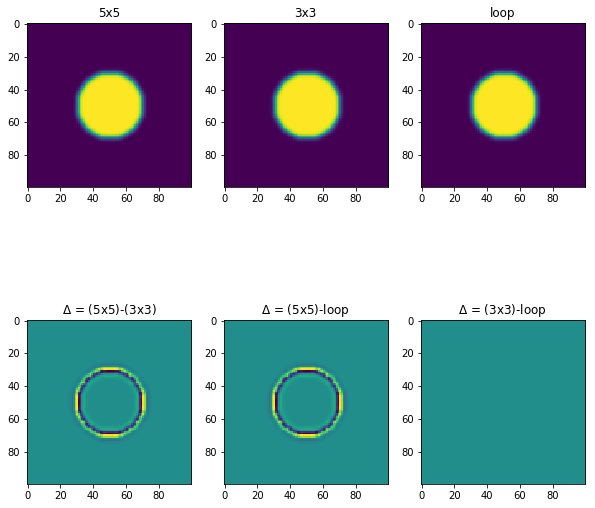

In [169]:
plotpar = {'vmin':0,'vmax':np.max([phinew_5,phinew_3,phinew_loop])} # apply same scale for all
diffs = [phinew_5-phinew_3,phinew_5-phinew_loop,phinew_3-phinew_loop]
print("min diff: ", np.min(diffs),"max diff: ",np.max(diffs))
plotpar_comp = {'vmin':np.min(diffs),'vmax':np.max(diffs)}

fig, ax = plt.subplots(2,3,figsize=(10,10))
fax = ax.ravel()
fax[0].imshow(phinew_5,**plotpar)
fax[0].set_title("5x5")
fax[1].imshow(phinew_3,**plotpar)
fax[1].set_title("3x3")
fax[2].imshow(phinew_loop,**plotpar)
fax[2].set_title("loop")
fax[3].imshow(phinew_5-phinew_3,**plotpar_comp)#,vmin=0,vmax=1) #normalize? which range?
fax[3].set_title("$\Delta$ = (5x5)-(3x3)")
fax[4].imshow(phinew_5-phinew_loop,**plotpar_comp)
fax[4].set_title("$\Delta$ = (5x5)-loop")
fax[5].imshow(phinew_3-phinew_loop,**plotpar_comp)
fax[5].set_title("$\Delta$ = (3x3)-loop")

fig.savefig('result_comp.png',tight_layout=True, dpi=200)

In [167]:
# compare runtimes
phiold_3 = np.copy(phi)
phiold_5 = np.copy(phi)
phiold_loop = np.copy(phi)
sigmaold_3 = np.copy(sigma)
sigmaold_5 = np.copy(sigma)
sigmaold_loop = np.copy(sigma)

avgs = {}
t_5 = %timeit -o integrate_5(phiold_5, sigmaold_5, S, **param)
avgs["5x5 conv"] = t_5.average * 10**3
t_3 = %timeit -o integrate_3(phiold_3, sigmaold_3, S, **param)
avgs["3x3 conv"] = t_3.average * 10**3
t_for = %timeit -o integrate_loop(phiold_loop, sigmaold_loop, S, **param)
avgs["for loop"] = t_for.average * 10**3

1.03 ms ± 76.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
860 µs ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
258 ms ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


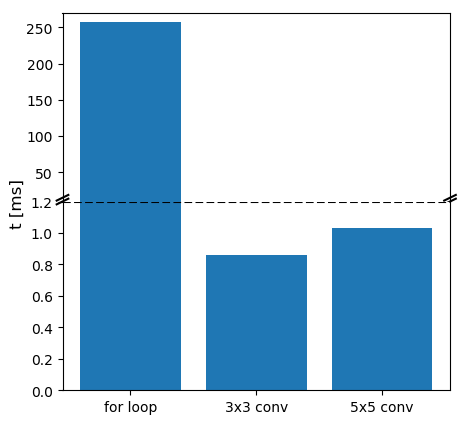

In [168]:
# plot for comparison
fig,(ax,ax2) = plt.subplots(2,1, sharex=True, figsize=(5,5),dpi=100)
ax.bar(range(len(avgs)), list(avgs.values()), align='center', tick_label=list(avgs.keys()))
ax.set_ylim(10,270)
ax2.bar(range(len(avgs)), list(avgs.values()), align='center', tick_label=list(avgs.keys()))
#ax2.set_ylabel("t [ms]") # would set it only on ax2
fig.text(0.02, 0.5, 't [ms]', va='center', rotation='vertical', size=12)
ax2.set_ylim(0,1.2)

ax2.axhline(1.2, linestyle = '--', color='black')

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(top=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
s = .02 # space between broken ax indicator
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 +s - d, 1+s + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1+s- d, 1+s+ d), **kwargs)  # bottom-right diagonal

fig.subplots_adjust(hspace=0)
fig.savefig('speed_comp.png',tight_layout=True, dpi=200)